# Imports

In [21]:
import string
import shutil
import torch
import random
import math
import h5py
import os
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from torch.optim import lr_scheduler
from google.colab import drive
from google.colab import runtime
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torchvision.datasets import MNIST
from torchvision import transforms
!pip install audiomentations
!pip install tensorboard
!pip install torchinfo
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, TimeMask

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

In [2]:
with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/test_data.h5', 'r') as test_file:
    test_data = np.array(test_file['data'])
    test_labels = np.array(test_file['labels'])

Data Augmentation

In [3]:
class DataAugmentation(nn.Module):
    def __init__(self):
        super(DataAugmentation, self).__init__()
        self.transforms = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            TimeMask(min_band_part=0.1, max_band_part=0.15, p=0.5),
        ])

    def forward(self, song, sample_rate):
        augmented_song = self.transforms(song, sample_rate=sample_rate)
        return augmented_song

Create Dataset

In [4]:
class AudioDataset(Dataset):
    def __init__(self, input_data, input_labels, sample_rate=16000, n_mels=128, mean=6.5304, std=11.8924, transform=None):
        self.input_data = input_data
        self.input_labels = input_labels
        self.sr = sample_rate
        self.n_mels = n_mels
        self.mean = mean
        self.std = std
        self.transform = transform
        self.mel_spec_transform = T.MelSpectrogram(sample_rate=self.sr, n_mels=self.n_mels, n_fft=2048, hop_length=512)
        self.log_mel_spec_transform = T.AmplitudeToDB()
        self.image_transforms = transform = v2.Compose([
                                                        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                                        v2.Normalize((self.mean,), (self.std,))
                                                    ])

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        song = self.input_data[idx]
        genre = self.input_labels[idx]
        if self.transform:
            song = self.transform(song, self.sr)

        mel_spec = self.mel_spec_transform(torch.from_numpy(song))
        log_mel_spec = self.log_mel_spec_transform(mel_spec)
        mel_spec_tensor = log_mel_spec.unsqueeze(0)
        mel_spec_tensor = self.image_transforms(mel_spec_tensor)

        return mel_spec_tensor, genre

batch_size=32

audio_train_dataset = AudioDataset(input_data=train_data, input_labels=train_labels, transform=DataAugmentation())
audio_val_dataset = AudioDataset(input_data=val_data, input_labels=val_labels, transform=None)
audio_test_dataset = AudioDataset(input_data=test_data, input_labels=test_labels, transform=None)

audio_train_loader = DataLoader(audio_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
audio_val_loader = DataLoader(audio_val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
audio_test_loader = DataLoader(audio_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Display Dataloader Images

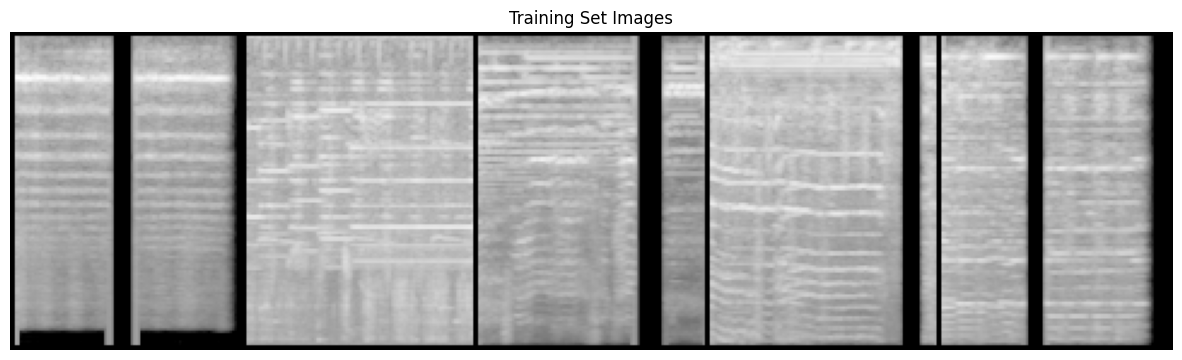

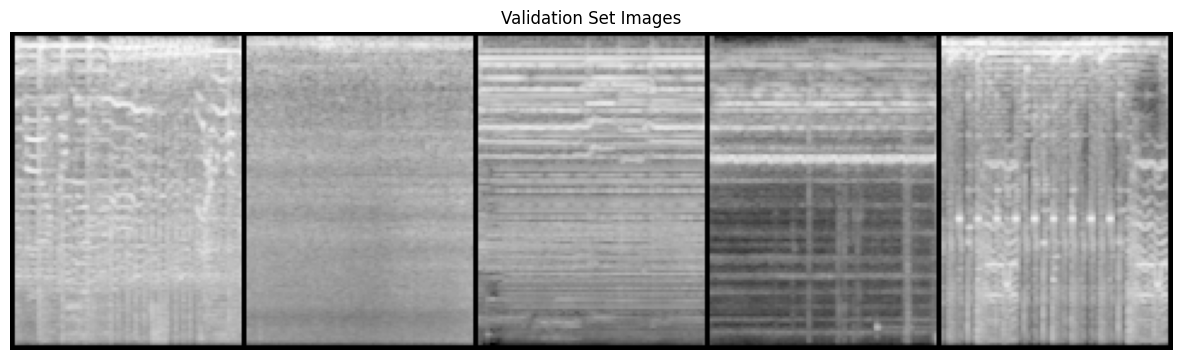

In [5]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    batch_size = images.shape[0]

    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    show_images(random_images, title=title)

plot_images_from_loader(audio_train_loader, title="Training Set Images")
plot_images_from_loader(audio_val_loader, title="Validation Set Images")

Mean and Stdev Calculation

In [6]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      nimages += batch.size(0)
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

def get_mean_std(data):
  mean = np.mean(data, axis=(0, 1, 2))
  std = np.std(data, axis=(0, 1, 2))
  return mean, std

# Model

Print Layer (debugging)

In [7]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        print("X shape:", x.shape)
        return x


Positional Encoding

In [8]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [9]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

Embedding Model

In [11]:
class ClassificationModel(nn.Module):
    def __init__(self):
      super(ClassificationModel, self).__init__()
      self.input_layer = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, bias=False),
          nn.SELU(),
      )

      self.conv_layers = nn.Sequential(
          ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=2, pool=True, short=True),
          ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=2, pool=True, short=True),
          ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=4, pool=True, short=True),
          ResidualBlock(in_channels=256, out_channels=512, kernel_size=3, num_layers=4, pool=True, short=True),
          nn.Dropout2d(0.2),
      )

      self.positional_encoding = PositionalEncoding2d(64, 128, 130)
      self.attention = nn.MultiheadAttention(embed_dim=16, num_heads=2, dropout=0.5, batch_first=True)

      self.dense_layers = nn.Sequential(
          nn.Linear(in_features=512, out_features=200, bias=False),
          nn.SELU(),
          nn.Linear(in_features=200, out_features=100, bias=False),
          nn.SELU(),
          nn.Linear(in_features=100, out_features=50, bias=False),
          nn.SELU(),
          nn.Dropout(0.5),
      )

      self.output = nn.Linear(50, 8)

    def forward(self, x):
      x = self.input_layer(x)
      x = self.conv_layers(x)
      x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
      x = self.dense_layers(x)
      out = self.output(x)
      return out

# Utils

Early Stopping

In [12]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.max_accuracy = float('-inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def reset_loss(self):
        self.min_validation_loss = float('inf')

Autoclip

In [13]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [14]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, train_accuracies, val_accuracies):
  checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
          'train_accuracies': train_accuracies,
          'val_accuracies': val_accuracies,
      }
  torch.save(checkpoint, f'/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_{epoch}.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses, train_accuracies, val_accuracies

# Training Loop

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = torch.cuda.is_available()
model = ClassificationModel().to(device)
start_epoch = 0
num_epochs = 100
learning_rate = 1e-3

classification_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)
early_stopping = EarlyStopping(patience=3)
autoclipper = AutoClip(percentile=10)

writer = SummaryWriter()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(summary(model, input_size=(batch_size, 1, 128, 94)))

checkpoint_path = '/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_95.pt'
if os.path.isfile(checkpoint_path):
    model, optimizer, scheduler, start_epoch, train_losses, val_losses, train_accuracies, val_accuracies = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
    print(f"Loaded checkpoint from epoch {start_epoch}")

def train_loop(train_loader, model, criterion, optimizer, device, epoch):
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    total_correct = 0
    total_samples = 0

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, targets)

        train_loss += loss.item()
        loss.backward()
        autoclipper(model)

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        optimizer.step()

    train_accuracy = 100 * total_correct / total_samples
    train_loss = train_loss / num_batches
    return train_loss, train_accuracy

def val_loop(val_loader, model, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)

            val_loss += loss.item()

    val_accuracy = 100 * total_correct / total_samples
    val_loss /= num_batches
    return val_loss, val_accuracy

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, train_accuracy = train_loop(audio_train_loader, model, classification_loss_fn, optimizer, device, epoch+1)
    val_loss, val_accuracy = val_loop(audio_val_loader, model, classification_loss_fn, device, epoch+1)
    print(f"Train loss: {train_loss:>8f} - Train Accuracy: {train_accuracy:>f} - Val loss: {val_loss:>8f} - Val Accuracy: {val_accuracy:>f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    save_checkpoint(model, optimizer, scheduler, epoch+1, train_losses, val_losses, train_accuracies, val_accuracies)

    # early_stop_result = early_stopping.early_stop(val_loss)
    # if early_stop_result:
    #     print(f"Early stopping after {epoch+1} epochs \n")
    #     print(f"Best val loss: {early_stopping.min_validation_loss} \n")
    #     break

    print("Last learning rate:", scheduler.get_last_lr())
    scheduler.step()

writer.close()

Layer (type:depth-idx)                        Output Shape              Param #
ClassificationModel                           [32, 8]                   1,088
├─Sequential: 1-1                             [32, 64, 124, 90]         --
│    └─Conv2d: 2-1                            [32, 64, 124, 90]         1,600
│    └─SELU: 2-2                              [32, 64, 124, 90]         --
├─Sequential: 1-2                             [32, 512, 8, 6]           --
│    └─ResidualBlock: 2-3                     [32, 64, 62, 45]          --
│    │    └─Sequential: 3-1                   [32, 64, 124, 90]         4,672
│    │    └─Sequential: 3-2                   [32, 64, 124, 90]         4,672
│    │    └─MaxPool2d: 3-3                    [32, 64, 62, 45]          --
│    │    └─Conv2d: 3-4                       [32, 64, 62, 45]          4,096
│    │    └─SELU: 3-5                         [32, 64, 62, 45]          --
│    └─ResidualBlock: 2-4                     [32, 128, 31, 23]         --
│    

100%|██████████| 1782/1782 [19:39<00:00,  1.51it/s]


Train loss: 0.109284 - Train Accuracy: 96.766274 - Val loss: 0.450183 - Val Accuracy: 90.572395 

Last learning rate: [1.204161903062634e-05]
Epoch 97
-------------------------------


100%|██████████| 1782/1782 [19:37<00:00,  1.51it/s]


Train loss: 0.112502 - Train Accuracy: 96.666316 - Val loss: 0.454221 - Val Accuracy: 90.516281 

Last learning rate: [8.85637463565564e-06]
Epoch 98
-------------------------------


100%|██████████| 1782/1782 [19:35<00:00,  1.52it/s]


Train loss: 0.111144 - Train Accuracy: 96.773288 - Val loss: 0.451558 - Val Accuracy: 90.600456 

Last learning rate: [6.155829702431171e-06]
Epoch 99
-------------------------------


100%|██████████| 1782/1782 [19:31<00:00,  1.52it/s]


Train loss: 0.112121 - Train Accuracy: 96.659301 - Val loss: 0.451725 - Val Accuracy: 90.558365 

Last learning rate: [3.942649342761118e-06]
Epoch 100
-------------------------------


100%|██████████| 1782/1782 [19:06<00:00,  1.55it/s]


Train loss: 0.113562 - Train Accuracy: 96.701389 - Val loss: 0.450954 - Val Accuracy: 90.572395 

Last learning rate: [2.2190176984600023e-06]


Training and Validation Loss Plots

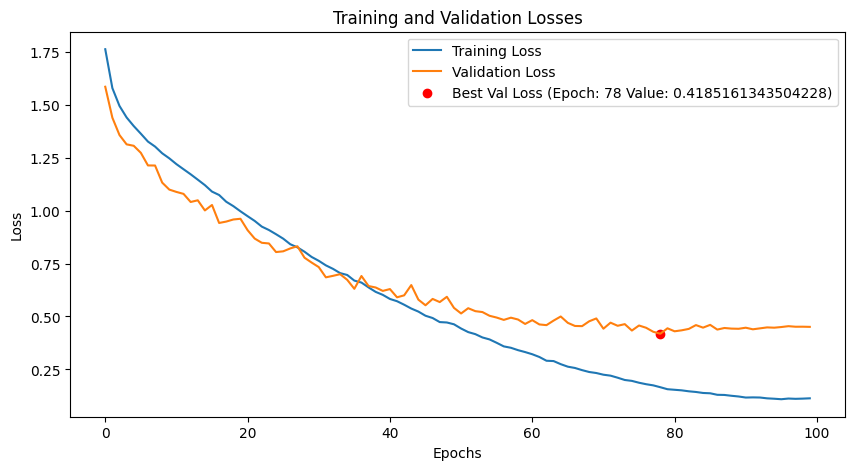

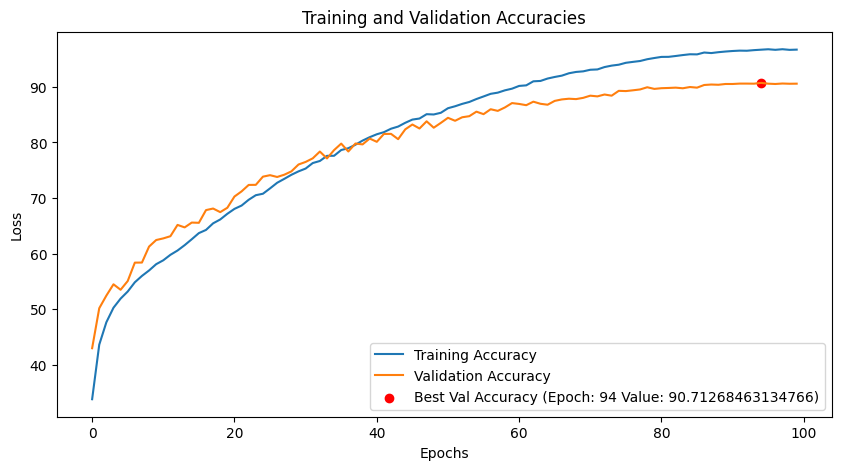

In [25]:
float_val_accuracies = [acc.item() for acc in val_accuracies] # Bug fix for accidentally adding tensor values and not items

best_val_loss = min(val_losses)
best_val_loss_epoch = val_losses.index(best_val_loss)

best_val_accuracy = max(float_val_accuracies)
best_val_accuracy_epoch = float_val_accuracies.index(best_val_accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.scatter(best_val_loss_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch: {best_val_loss_epoch} Value: {best_val_loss})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(float_val_accuracies, label='Validation Accuracy')
plt.scatter(best_val_accuracy_epoch, best_val_accuracy, color='red', label=f'Best Val Accuracy (Epoch: {best_val_accuracy_epoch} Value: {best_val_accuracy})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Accuracies')
plt.show()

Testing Set Accuracy

In [26]:
num_correct = 0
num_samples = 0
all_predictions = []
all_targets = []

model.eval()

with torch.no_grad():
    for inputs, targets in audio_test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        _, predictions = torch.max(outputs.data, 1)

        num_correct += (predictions == targets).sum().item()
        num_samples += predictions.size(0)

        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

accuracy = float(num_correct) / float(num_samples) * 100
print(f'Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')

print("Classification Report:")
print(classification_report(all_targets, all_predictions, digits=4))

Got 6444 / 7128 with accuracy 90.40
Classification Report:
              precision    recall  f1-score   support

           0     0.9028    0.9068    0.9048       891
           1     0.8876    0.8687    0.8780       891
           2     0.8905    0.9125    0.9013       891
           3     0.9229    0.9405    0.9316       891
           4     0.9046    0.9046    0.9046       891
           5     0.9509    0.9349    0.9428       891
           6     0.8617    0.8462    0.8539       891
           7     0.9109    0.9181    0.9145       891

    accuracy                         0.9040      7128
   macro avg     0.9040    0.9040    0.9040      7128
weighted avg     0.9040    0.9040    0.9040      7128



In [20]:
torch.save(model.state_dict(), "/content/drive/My Drive/Projects/NeuraBeat/classification_model.pt")

In [ ]:
runtime.unassign()